In [22]:
import torch
from torchvision import transforms
import os
import PIL

from utils.model_utils import get_model
from utils.image_utils import std_filter

from strategies import genetic_strategy
from strategies import lbfgs_strategy
from strategies import uniform_sampling_strategy

from density_recorder.density_recorder import measure_post_relu_density

import matplotlib.pyplot as plt


"""
This script showcases how to use the strategies to generate sponge examples and measure their post-relu density as well as the amount of uniform surfaces.
1. random image
2. Uniform Sampling Strategy
3. Natural Sampling (most densely activating image from ImageNet)
4. Sponge-GA Strategy
5. Sponge-LBFGS Strategy

Resulting images will be in the 'results' folder.

Note that Sponge-GA and Sponge-LBFGS strategies are computationally expensive so we reduced the parameters.
The parameters used for the paper are noted in the comments.
"""

"\nThis script showcases how to use the strategies to generate sponge examples and measure their post-relu density as well as the amount of uniform surfaces.\n1. random image\n2. Uniform Sampling Strategy\n3. Natural Sampling (most densely activating image from ImageNet)\n4. Sponge-GA Strategy\n5. Sponge-LBFGS Strategy\n\nResulting images will be in the 'results' folder.\n\nNote that Sponge-GA and Sponge-LBFGS strategies are computationally expensive so we reduced the parameters.\nThe parameters used for the paper are noted in the comments.\n"

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_model = get_model('ResNet18', device=device)

# 1. simple random image

                 Random Image:             post ReLU density:                         0.5942    amount of uniform surfaces:                         0.1656


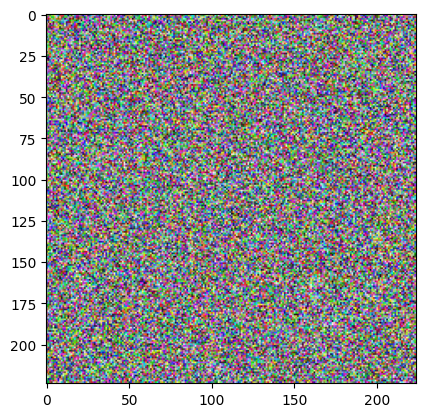

In [24]:
image_shape = (1, 3, 224, 224)
random_image = torch.rand(image_shape, dtype=torch.float32, requires_grad=False).to(device)  # don't forget the batch dimension
assert random_image.shape == (1, 3, 224, 224)

# measure density and amount of uniform surface
random_image_density = measure_post_relu_density(input=random_image, model=target_model, batch_size=1, device=device)[0].item()
random_image_uniform_surface = std_filter(img=random_image, width=7, device=device)[0].item()
print('{: >30} {: >30} {: >30.4f} {: >30} {: >30.4f}'.format('Random Image:',
                                                             'post ReLU density:', random_image_density,
                                                             'amount of uniform surfaces:', random_image_uniform_surface))  # low means more uniform surfaces

# remove batch dimension
random_image = random_image.squeeze(0)

# show
random_image = random_image.permute(1, 2, 0).numpy()
os.makedirs('results', exist_ok=True)
plt.imsave('results/random.png', random_image)
plt.imshow(random_image)
plt.show()

# 2. Uniform Sampling Strategy

    Uniform Sampling Strategy:             post ReLU density:                         0.6664    amount of uniform surfaces:                         0.0045


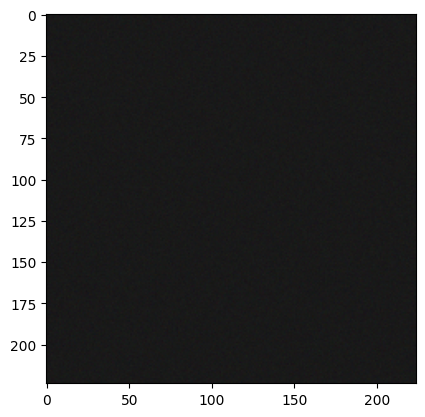

In [25]:
uniform_sampling = uniform_sampling_strategy.generate(
    mean=0.1,  # 0.1 is optimal for ResNet18
    std=2/255,  # 2/255 is optimal for ResNet18
    amount=1,
)

assert uniform_sampling.shape == (1, 3, 224, 224)

# measure density and amount of uniform surface
uniform_sampling_density = measure_post_relu_density(input=uniform_sampling, model=target_model, batch_size=1, device=device)[0].item()
uniform_sampling_uniform_surface = std_filter(img=uniform_sampling, width=7, device=device)[0].item()
print('{: >30} {: >30} {: >30.4f} {: >30} {: >30.4f}'.format('Uniform Sampling Strategy:',
                                                             'post ReLU density:', uniform_sampling_density,
                                                             'amount of uniform surfaces:', uniform_sampling_uniform_surface))  # low means more uniform surfaces

# remove batch dimension
uniform_sampling = uniform_sampling.squeeze(0)

# show
uniform_sampling = uniform_sampling.permute(1, 2, 0).numpy()
os.makedirs('results', exist_ok=True)
plt.imsave('results/uniform_sampling.png', uniform_sampling)
plt.imshow(uniform_sampling)
plt.show()

# 3. Most Densely Activated Natural Image Strategy

    Natural Sampling Strategy:             post ReLU density:                         0.6640    amount of uniform surfaces:                         0.0084


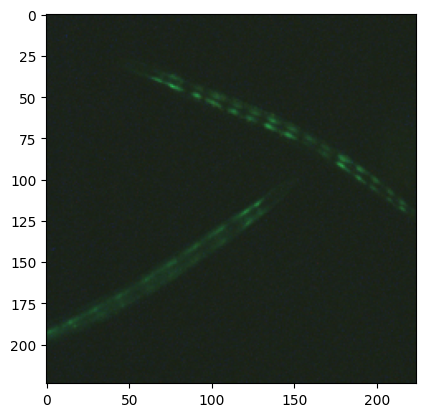

In [26]:
# We picked the most densly activating image from the ImageNet validation dataset when measured with ResNet18.
natural_sampling = transforms.ToTensor()(PIL.Image.open('most_dense_imagenet_samples/ResNet18.png').convert('RGB')).unsqueeze(0)

assert natural_sampling.shape == (1, 3, 224, 224)

# measure density and amount of uniform surface
natural_sampling_density = measure_post_relu_density(input=natural_sampling, model=target_model, batch_size=1, device=device)[0].item()
natural_sampling_uniform_surface = std_filter(img=natural_sampling, width=7, device=device)[0].item()
print('{: >30} {: >30} {: >30.4f} {: >30} {: >30.4f}'.format('Natural Sampling Strategy:',
                                                             'post ReLU density:', natural_sampling_density,
                                                             'amount of uniform surfaces:', natural_sampling_uniform_surface))  # low means more uniform surfaces

# remove batch dimension
natural_sampling = natural_sampling.squeeze(0)

# show
natural_sampling = natural_sampling.permute(1, 2, 0).numpy()
os.makedirs('results', exist_ok=True)
plt.imsave('results/natural_sampling.png', natural_sampling)
plt.imshow(natural_sampling)
plt.show()

# 4. Sponge-GA Strategy

           Sponge-GA Strategy:             post ReLU density:                         0.6354    amount of uniform surfaces:                         0.0690


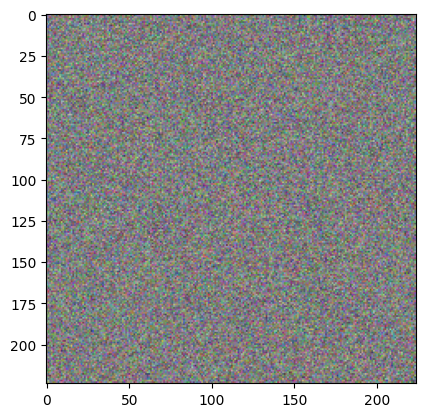

In [27]:
if not os.path.isfile('results/sponge-genetic.png'):  # caching
    sponge_genetic = genetic_strategy.generate(target_model=target_model,
                                               iterations=10,  # We used 250 in the paper
                                               pool_size=100,  # We used 1000 in the paper
                                               batch_size=256,  # batch size of 256 is fine for ResNet18 model on A30 GPU
                                               device=device,
                                               print_progress=True)  # has shape (224, 224, 3)
else:
    sponge_genetic = transforms.ToTensor()(PIL.Image.open('results/sponge-genetic.png').convert('RGB')).unsqueeze(0)

assert sponge_genetic.shape == (1, 3, 224, 224)

# measure density and amount of uniform surface
sponge_genetic_density = measure_post_relu_density(input=sponge_genetic, model=target_model, batch_size=1, device=device)[0].item()
sponge_genetic_uniform_surface = std_filter(img=sponge_genetic, width=7, device=device)[0].item()
print('{: >30} {: >30} {: >30.4f} {: >30} {: >30.4f}'.format('Sponge-GA Strategy:',
                                                             'post ReLU density:', sponge_genetic_density,
                                                             'amount of uniform surfaces:', sponge_genetic_uniform_surface))  # low means more uniform surfaces

# remove batch dimension
sponge_genetic = sponge_genetic.squeeze(0)

# show
sponge_genetic = sponge_genetic.permute(1, 2, 0).numpy()
os.makedirs('results', exist_ok=True)
plt.imsave('results/sponge-genetic.png', sponge_genetic)
plt.imshow(sponge_genetic)
plt.show()

# 5. Sponge-LBFGS Strategy

        Sponge-LBFGS Strategy:             post ReLU density:                         0.6479    amount of uniform surfaces:                         0.0748


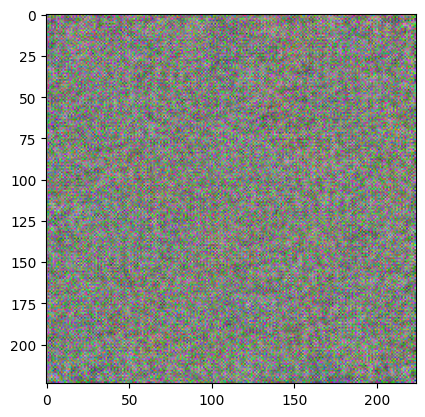

In [28]:
if not os.path.isfile('results/sponge-lbfgs.png'):  # caching
    sponge_lbfgs = lbfgs_strategy.generate(target_model=target_model,
                                           epochs=5,  # We used 500 in the paper
                                           device=device,
                                           print_progress=True)
else:
    sponge_lbfgs = transforms.ToTensor()(PIL.Image.open('results/sponge-lbfgs.png').convert('RGB')).unsqueeze(0)

assert sponge_lbfgs.shape == (1, 3, 224, 224)

# measure density and amount of uniform surface
sponge_lbfgs_density = measure_post_relu_density(input=sponge_lbfgs, model=target_model, batch_size=1, device=device)[0].item()
sponge_lbfgs_uniform_surface = std_filter(img=sponge_lbfgs, width=7, device=device)[0].item()
print('{: >30} {: >30} {: >30.4f} {: >30} {: >30.4f}'.format('Sponge-LBFGS Strategy:',
                                                             'post ReLU density:', sponge_lbfgs_density,
                                                             'amount of uniform surfaces:', sponge_lbfgs_uniform_surface))  # low means more uniform surfaces

# remove batch dimension
sponge_lbfgs = sponge_lbfgs.squeeze(0)

# show
sponge_lbfgs = sponge_lbfgs.permute(1, 2, 0).numpy()
os.makedirs('results', exist_ok=True)
plt.imsave('results/sponge-lbfgs.png', sponge_lbfgs)
plt.imshow(sponge_lbfgs)
plt.show()